In [28]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns
from nltk.corpus import stopwords 
from nltk.stem.lancaster import LancasterStemmer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm

First we have to load the data by using read_csv function of pandas library.

In [29]:
data = pd.read_csv('train.csv')
data=data.head(1500)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## EDA 

In [30]:
# Check percentage of comments that are toxic compared to normal comments
print(data.toxic.value_counts(normalize=True))
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()
data_count

0    0.902667
1    0.097333
Name: toxic, dtype: float64


toxic            146
severe_toxic      16
obscene           71
threat             8
insult            72
identity_hate     15
dtype: int64

C:\Users\Barde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


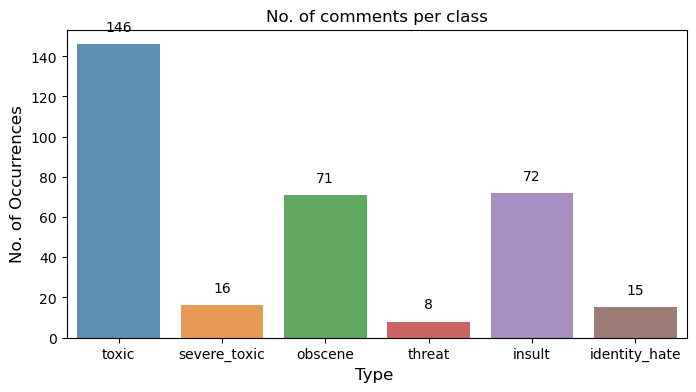

In [31]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

After that we have plotted bar graph with with x-axis as column name and y-axis as no of toxic comments

1500


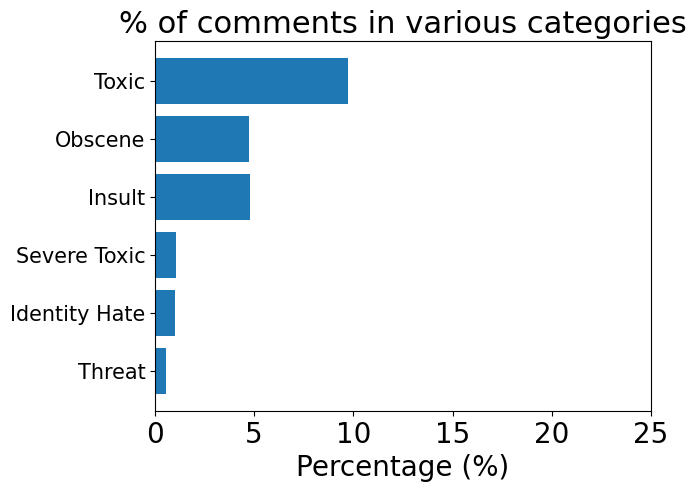

In [32]:
num_rows = len(data)
print(num_rows)
# Create a bar graph 
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


## Preprocess the text

In [33]:
# Stopwords are a list of 'useless' words
l=set(stopwords.words('english'))

In [34]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
#Removing stop words from comments
stop = lambda x :re.sub('l',"",x)
# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii).map(stop)

data['comment_text'][0]

'expanation why the edits made under my username hardcore metaica fan were reverted  they weren t vandaisms  just cosure on some gas after i voted at new york dos fac  and pease don t remove the tempate from the tak page since i m retired now        '

Then next step is preprocesing, 
first we are removing all numbers with letters attached to it for that we are using regular expression library and
using sub method to replace all numbers with letters attched to it, then removing punctuation.
After that we are converting string into lower case. Then removing newline and non ascii chacracters from it.
For removing stop words,first I have taken all the stop words of enlish language into list and then removed that.

## Separate our dataset into 6 sections. Each section is comment + 1 category.

In [35]:
data_tox = data.loc[:,['id','comment_text','toxic']]
data_sev = data.loc[:,['id','comment_text','severe_toxic']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_thr = data.loc[:,['id','comment_text','threat']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]

## Creating WordCloud

In [36]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [39]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="white",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

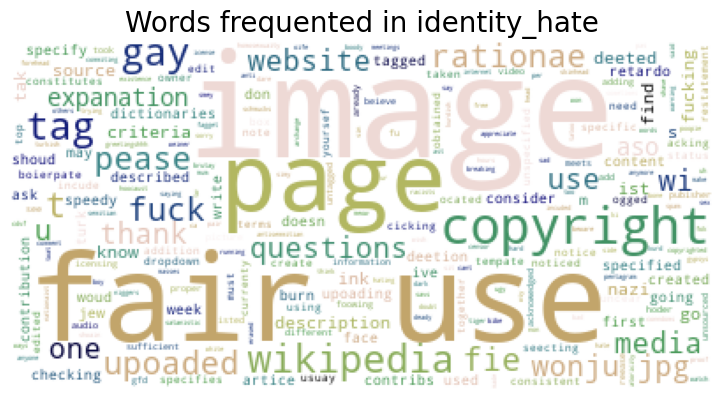

In [40]:
wordcloud(data_ide,'identity_hate')

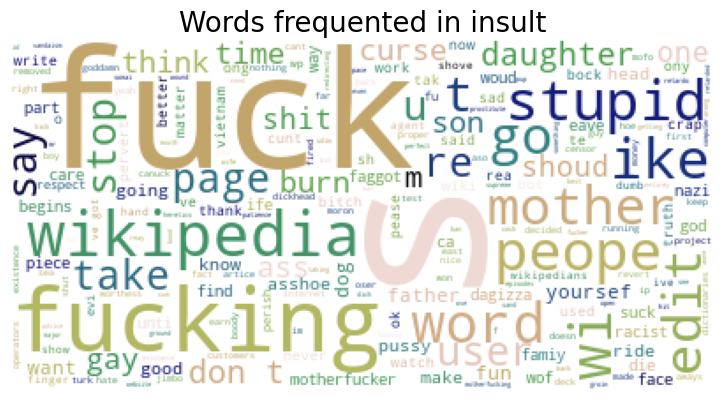

In [41]:
wordcloud(data_ins, 'insult')

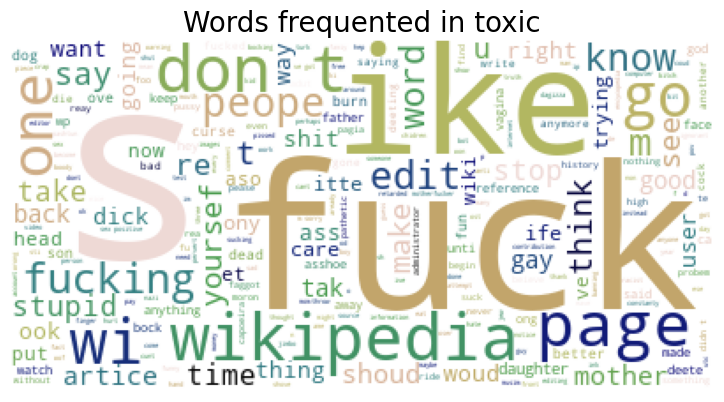

In [42]:
wordcloud(data_tox,'toxic')

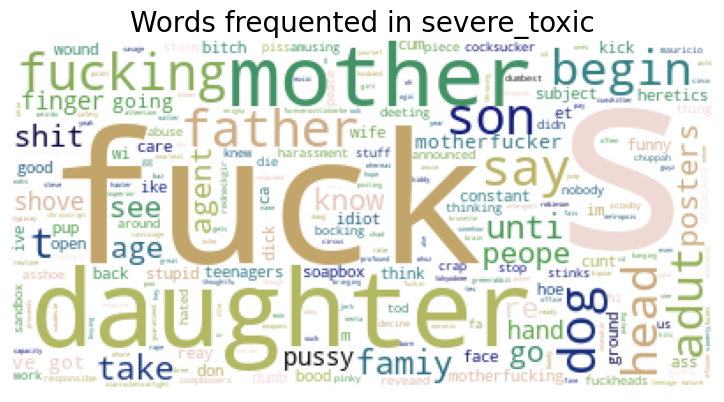

In [43]:
wordcloud(data_sev,'severe_toxic')

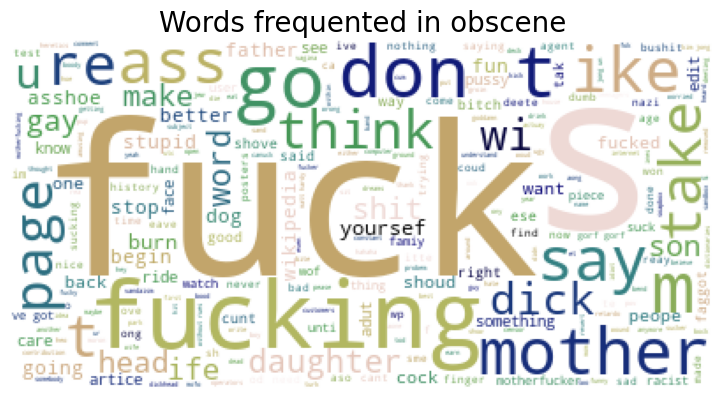

In [44]:
wordcloud(data_obs,'obscene')

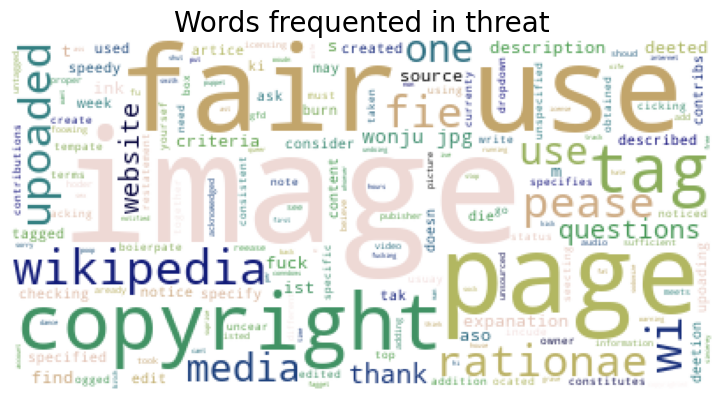

In [45]:
wordcloud(data_thr,'threat')

Wordcloud is created for each column.

In [46]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
print(data_tox_1.shape)
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
print(data_tox_done.shape)

(146, 3)
(1500, 3)


# Not all categories have 1500 rows. So we should count them first and make them balanced.

In [48]:
data_sev[data_sev['severe_toxic'] == 1].count()
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
print(data_sev_done.shape)
data_obs[data_obs['obscene'] == 1].count()
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
print(data_obs_done.shape)
data_thr[data_thr['threat'] == 1].count()
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
print(data_thr_done.shape)
data_ins[data_ins['insult'] == 1].count()
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
print(data_ins_done.shape)
data_ide[data_ide['identity_hate'] == 1].count()
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
print(data_ide_done.shape)


(1500, 3)
(1500, 3)
(1500, 3)
(1500, 3)
(1500, 3)


Reminder: Number of comments that fall into the following categories:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

In [49]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Import relevant packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # Remove useless words
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form; aggressive

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import accuracy_score,hamming_loss,classification_report,roc_auc_score,log_loss
from sklearn.model_selection import RandomizedSearchCV

In [50]:
'''
df_done: data_tox_done, data_sev_done, ...
label: toxic, severe_toxic, ...
vectorizer values: CountVectorizer, TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
df_done=data
label='toxic'
label1='severe_toxic'
label2='obscene'
label3='threat'
label4='insult'
label5='identity_hate'
''' Train/Test split'''
# Split the data into X and y data sets
X = df_done.comment_text
y = df_done[[label,label1,label2,label3,label4,label5]]
# Split our data into training and test data 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1050,), (450,), (1050, 6), (450, 6))

In [51]:
''' BoW'''

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')
#fitting it to convert comments into bow format
Count_data1 = CountVec.fit(x_train)
Count_data = CountVec.fit(x_test)

#create dataframe
cv_test=pd.DataFrame(Count_data.transform(x_test).todense(),columns=CountVec.get_feature_names())
cv_train=pd.DataFrame(Count_data1.transform(x_train).todense(),columns=CountVec.get_feature_names())
print(cv_train.shape,cv_test.shape,y_train.shape,y_test.shape)

(1050, 4887) (450, 4887) (1050, 6) (450, 6)


In [52]:
#defining list of base-classifiers
clf_list=[GaussianNB(),LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),XGBClassifier()]

#metrics list
acc=[]
ham_loss=[]
logloss=[]
avg_auc=[]

#training with CC
for base_clf in tqdm(clf_list):
    clf = ClassifierChain(base_clf)
    clf.fit(cv_train, y_train)
    pred = clf.predict(cv_test)
    pred_proba=clf.predict_proba(cv_test)
    acc.append(accuracy_score(y_test,pred))
    avg_auc.append(np.mean(roc_auc_score(y_test, pred_proba.A,
                                         average=None)))
    ham_loss.append(hamming_loss(y_test,pred))
    logloss.append(log_loss(y_test,pred.A))
   
        

#Creating data-frame to see results in a table format     
clf_chain_res=pd.DataFrame(columns=['Classifier','Exact Match Ratio (Accuracy)',
                                  'Average AUC','Hamming-Loss','Log-Loss'])
clf_chain_res['Classifier']=['Gaussian NB','Logistic Regression',
                             'Decision Tree','Random Forest','XGBoost']
clf_chain_res['Exact Match Ratio (Accuracy)']=acc
clf_chain_res['Hamming-Loss']=ham_loss
clf_chain_res['Log-Loss']=logloss
clf_chain_res['Average AUC']=avg_auc
clf_chain_res

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:24<00:00, 16.99s/it]


,Classifier,Exact Match Ratio (Accuracy),Average AUC,Hamming-Loss,Log-Loss
0,Gaussian NB,0.840000,0.569146,0.052222,1.138696
1,Logistic Regression,0.891111,0.843588,0.031481,0.691463
2,Decision Tree,0.848889,0.669121,0.043333,1.019544
3,Random Forest,0.891111,0.774850,0.032222,0.840202
4,XGBoost,0.871111,0.666219,0.037407,0.624823


In [53]:
''' TF-IDF '''
vectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
#fitting it to convert comments into bow format
Count_data1 = vectorizer.fit(x_train)
Count_data = vectorizer.fit(x_test)

#create dataframe
tfidf_test=pd.DataFrame(Count_data.transform(x_test).todense(),columns=CountVec.get_feature_names())
tfidf_train=pd.DataFrame(Count_data1.transform(x_train).todense(),columns=CountVec.get_feature_names())
print(tfidf_train.shape,tfidf_test.shape,y_train.shape,y_test.shape)

(1050, 4887) (450, 4887) (1050, 6) (450, 6)


In [54]:
tfidf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())


In [55]:


#defining list of base-classifiers
clf_list=[GaussianNB(),LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),XGBClassifier()]

#metrics list
acc=[]
ham_loss=[]
logloss=[]
avg_auc=[]

#training with CC
for base_clf in tqdm(clf_list):
    clf = ClassifierChain(base_clf)
    clf.fit(tfidf_train, y_train)
    pred = clf.predict(tfidf_test)
    pred_proba=clf.predict_proba(tfidf_test)
    acc.append(accuracy_score(y_test,pred))
    avg_auc.append(np.mean(roc_auc_score(y_test, pred_proba.A,average=None)))
    ham_loss.append(hamming_loss(y_test,pred))
    logloss.append(log_loss(y_test,pred.A))

#Creating data-frame to see results in a table format     
clf_chain_res=pd.DataFrame(columns=['Classifier','Exact Match Ratio (Accuracy)',
                                  'Average AUC','Hamming-Loss','Log-Loss'])
clf_chain_res['Classifier']=['Gaussian NB','Logistic Regression',
                             'Decision Tree','Random Forest','XGBoost']
clf_chain_res['Exact Match Ratio (Accuracy)']=acc
clf_chain_res['Hamming-Loss']=ham_loss
clf_chain_res['Log-Loss']=logloss
clf_chain_res['Average AUC']=avg_auc
clf_chain_res

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:22<00:00, 16.47s/it]


,Classifier,Exact Match Ratio (Accuracy),Average AUC,Hamming-Loss,Log-Loss
0,Gaussian NB,0.842222,0.554331,0.053704,0.930410
1,Logistic Regression,0.886667,0.765832,0.038519,0.436068
2,Decision Tree,0.871111,0.703428,0.032593,1.973064
3,Random Forest,0.893333,0.811467,0.032593,0.562603
4,XGBoost,0.882222,0.725721,0.034444,0.692188


### tfidf_weighted_w2v

In [56]:
w2v_dict = dict()
glove_data='glove.6B.300d.txt'
f = open(glove_data, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')     
    w2v_dict[word] = vec
f.close()
print('Loaded %s word vectors.' % len(w2v_dict))
w2v_words =  set(w2v_dict.keys())


Loaded 400000 word vectors.


In [57]:
vectorizer = TfidfVectorizer(min_df=10,
                             ngram_range=(1,1),
                             use_idf=True)
vectorizer.fit(x_train)

# saving a dictionary with word as a key, and the idf as a value
tfidf_dict = dict(zip(vectorizer.get_feature_names(),
                      list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())


In [58]:
def comp_tfidf_weighted_w2v(data,w2v_words,tfidf_words,w2v_dict,tfidf_dict):
    """function to calculate TF-IDF weighted avg W2V"""    
    tfidf_w2v = []
    for sentence in tqdm(data):
        vector = np.zeros(300) 
        # word vectors are of zeros with 300-length
        tf_idf_weight =0;
        # num of words with a valid vector in the sentence
        try:
            for word in sentence.split():
                # for each word in a sentence
                if (word in w2v_words) and (word in tfidf_words):
                    vec = w2v_dict[word] 
                    # getting the vector for each word
                    # here we are multiplying idf value(dictionary[word]) and 
                    #the tf value((sentence.count(word)/len(sentence.split())))
                    tf_idf = tfidf_dict[word]*(sentence.count(word)/len(sentence.split()))
                    # getting the tfidf value for each word
                    vector += (vec * tf_idf) # calculating tfidf weighted w2v
                    tf_idf_weight += tf_idf
        except:
            tf_idf_weight =0
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v.append(vector)
    return np.array(tfidf_w2v)

In [59]:
x_train_tfidf_w2v=comp_tfidf_weighted_w2v(x_train.values,
                                              w2v_words,tfidf_words,
                                              w2v_dict,tfidf_dict)
x_test_tfidf_w2v=comp_tfidf_weighted_w2v(x_test.values,
                                             w2v_words,tfidf_words,
                                             w2v_dict,tfidf_dict)
#printing shapes
print("Shape of X-Train data=",x_train_tfidf_w2v.shape)
print("Shape of X-Test data=",x_test_tfidf_w2v.shape)

# Shape of X-Train data= (111434, 300)
# Shape of X-Test data= (47758, 300)
print(y_train.shape,y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 466.02it/s]

Shape of X-Train data= (1050, 300)
Shape of X-Test data= (450, 300)
(1050, 6) (450, 6)


In [60]:

x_train_tfidf_w2v=comp_tfidf_weighted_w2v(x_train.values,
                                              w2v_words,tfidf_words,
                                              w2v_dict,tfidf_dict)
x_test_tfidf_w2v=comp_tfidf_weighted_w2v(x_test.values,
                                             w2v_words,tfidf_words,
                                             w2v_dict,tfidf_dict)
#printing shapes
print("Shape of X-Train data=",x_train_tfidf_w2v.shape)
print("Shape of X-Test data=",x_test_tfidf_w2v.shape)

# Shape of X-Train data= (111434, 300)
# Shape of X-Test data= (47758, 300)
print(y_train.shape,y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 638.10it/s]

Shape of X-Train data= (1050, 300)
Shape of X-Test data= (450, 300)
(1050, 6) (450, 6)


In [61]:

#defining list of base-classifiers
clf_list=[GaussianNB(),LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),XGBClassifier()]

#metrics list
acc=[]
ham_loss=[]
logloss=[]
avg_auc=[]

#training with BR
for base_clf in tqdm(clf_list):
    clf = ClassifierChain(base_clf)
    clf.fit(x_train_tfidf_w2v, y_train)
    pred = clf.predict(x_test_tfidf_w2v)
    pred_proba=clf.predict_proba(x_test_tfidf_w2v)
    acc.append(accuracy_score(y_test,pred))
    avg_auc.append(np.mean(roc_auc_score(y_test, pred_proba.A,
                                         average=None)))
    ham_loss.append(hamming_loss(y_test,pred))
    logloss.append(log_loss(y_test,pred.A))

#creating data-frame to see results in a table format
bin_rel_res=pd.DataFrame(columns=['Classifier','Exact Match Ratio (Accuracy)','Average AUC',
                                  'Hamming-Loss','Log-Loss'])
bin_rel_res['Classifier']=['Gaussian NB','Logistic Regression',
                           'Decision Tree','Random Forest','XGBoost']
bin_rel_res['Exact Match Ratio (Accuracy)']=acc
bin_rel_res['Hamming-Loss']=ham_loss
bin_rel_res['Log-Loss']=logloss
bin_rel_res['Average AUC']=avg_auc
bin_rel_res


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.87s/it]


,Classifier,Exact Match Ratio (Accuracy),Average AUC,Hamming-Loss,Log-Loss
0,Gaussian NB,0.733333,0.756419,0.123333,1.743825
1,Logistic Regression,0.882222,0.848713,0.036296,0.983565
2,Decision Tree,0.793333,0.575236,0.070370,1.220362
3,Random Forest,0.886667,0.843395,0.035185,0.993917
4,XGBoost,0.877778,0.838402,0.037778,0.556064


In [62]:

#defining list of base-classifiers
base_clf=LogisticRegression()
          

#metrics list
acc=[]
ham_loss=[]
logloss=[]
avg_auc=[]

#training with BR

clf = ClassifierChain(base_clf)
clf.fit(x_train_tfidf_w2v, y_train)
pred = clf.predict(x_test_tfidf_w2v)
pred_proba=clf.predict_proba(x_test_tfidf_w2v)
acc.append(accuracy_score(y_test,pred))
avg_auc.append(np.mean(roc_auc_score(y_test, pred_proba.A,
                                     average=None)))
ham_loss.append(hamming_loss(y_test,pred))
logloss.append(log_loss(y_test,pred.A))

#creating data-frame to see results in a table format
bin_rel_res=pd.DataFrame(columns=['Classifier','Exact Match Ratio (Accuracy)','Average AUC',
                                  'Hamming-Loss','Log-Loss'])


bin_rel_res['Classifier']=['Logistic Regression']
bin_rel_res['Exact Match Ratio (Accuracy)']=acc


bin_rel_res['Hamming-Loss']=ham_loss
bin_rel_res['Log-Loss']=logloss
bin_rel_res['Average AUC']=avg_auc
bin_rel_res


,Classifier,Exact Match Ratio (Accuracy),Average AUC,Hamming-Loss,Log-Loss
0,Logistic Regression,0.882222,0.848713,0.036296,0.983565
